# Demo of the pipeline

In [14]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt

Let's look at our demo dataset. It consists on 3 files:
* 'demo/demo_pipeline_input.pkl': a pickled pandas dataframe with the raw data, with only one entry
* 'demo/img/street_cats_324w.jpg': a picture of a cats in the street, with a width of 324 pixels
* 'demo/img/street_cats_2975h.jpg': a picture of a cats in the street, with a height of 2975 pixels

In [36]:
pd.read_pickle('demo/demo_pipeline_input.pkl')

,bcu_id,title,caption
0,street_cats,L'heure du petit déjeuner est respectée - [Fri...,a group of cats sitting on a street


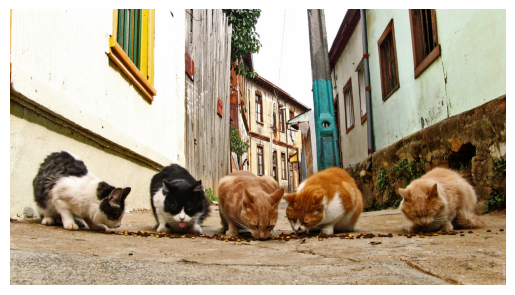

In [37]:
plt.imshow(plt.imread('demo/img/street_cats_2975h.jpg'))
plt.axis('off');

## 1: Translation of the title from French to English
Let's first check the title of the image:

In [38]:
print(f'The title in French: {pd.read_pickle("demo/demo_pipeline_input.pkl").iloc[0]["title"]}')
pd.read_pickle('demo/demo_pipeline_input.pkl')

The title in French: L'heure du petit déjeuner est respectée - [Fribourg]


,bcu_id,title,caption
0,street_cats,L'heure du petit déjeuner est respectée - [Fri...,a group of cats sitting on a street


In [39]:
!python pipeline/1_translate.py --input_file demo/demo_pipeline_input.pkl --column title --output_file demo/1_translation.pkl --device cuda

  0%|                                                     | 0/1 [00:00<?, ?it/s]/home/tgieruc/miniconda3/envs/bcu/lib/python3.10/site-packages/transformers/generation_utils.py:1227: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
2023-01-09 17:01:58.242198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-09 17:01:58.435329: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: 

Let's see the new dataframe and title:

In [40]:
print(f'The translated title: {pd.read_pickle("demo/1_translation.pkl").iloc[0]["title_en"]}')
pd.read_pickle('demo/1_translation.pkl')

The translated title: Breakfast time is respected - [Fribourg]


,bcu_id,title,caption,title_en
0,street_cats,L'heure du petit déjeuner est respectée - [Fri...,a group of cats sitting on a street,Breakfast time is respected - [Fribourg]


## 2: The preprocessing 
We will preprocess the captions and titles for preparing them for the Phrase Grounding model. We will also link the image filenames to the dataframe.

In [42]:
!python pipeline/2_preprocessing.py --input_file demo/1_translation.pkl --id_column bcu_id --image_directory demo/img --output_file demo/2_preprocessing.pkl --quality 324w --columns_to_preprocess caption title_en


In [44]:
p2_preprocessing = pd.read_pickle('demo/2_preprocessing.pkl')
print('The new information:')
print(f' - The preprocessed caption: {p2_preprocessing.iloc[0]["caption_preprocessed"]}')
print(f' - The preprocessed title: {p2_preprocessing.iloc[0]["title_en_preprocessed"]}')
print(f' - The image path: {p2_preprocessing.iloc[0]["filename"]}')
p2_preprocessing


The new information:
 - The preprocessed caption:  cats sitting on a street
 - The preprocessed title: breakfast time is respected - 
 - The image path: street_cats_324w.jpg


,bcu_id,title,caption,title_en,filename,caption_preprocessed,title_en_preprocessed
0,street_cats,L'heure du petit déjeuner est respectée - [Fri...,a group of cats sitting on a street,Breakfast time is respected - [Fribourg],street_cats_324w.jpg,cats sitting on a street,breakfast time is respected -
